In [1]:
%matplotlib inline

import json
from typing import List

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.pylabtools import figsize

In [2]:
sns.__version__

'0.11.2'

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
figsize(15, 9)
figsize(15, 9)

In [5]:
with open("results.json", "r") as istream:
    stats = json.load(istream)

In [6]:
rows = []
for name, history in stats.items():
    for g in history:
        rows.append({"guesses": g, "strategy": name})
df = pd.DataFrame(rows)

df.head()

,guesses,strategy
0,4,StrategyFilterOnFeedback
1,17,StrategyFilterOnFeedback
2,9,StrategyFilterOnFeedback
3,4,StrategyFilterOnFeedback
4,9,StrategyFilterOnFeedback


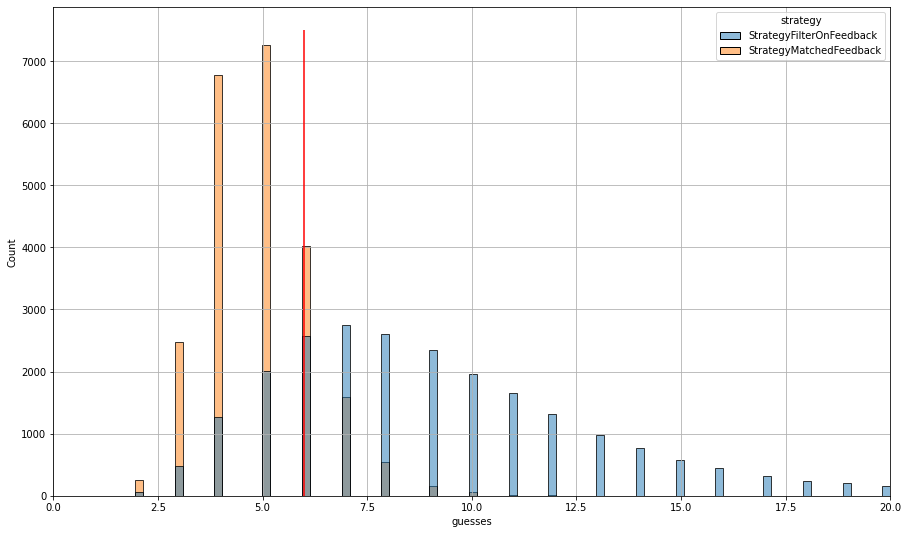

In [7]:
ignored_strategies = [
#     'StrategyRandomWithReplacement',
#     'StrategyRandomWithoutReplacement',
#     'StrategyFilterOnFeedback',
#     'StrategyMatchedFeedback',
]
sns.histplot(
    x="guesses",
    hue="strategy",
    data=df[
        (~df['strategy'].isin(ignored_strategies)) &
        (df["guesses"] <= 20)
    ],
    bins=100,
    stat='count',
)
plt.vlines(6, 0, 7500, color='r')
plt.xlim(0, 20)
plt.grid()
plt.show()